In [ ]:
# %% Cell 1: Import Libraries and Set Random Seeds
"""
Import all required libraries and set seeds for reproducibility.
We use PyTorch, NumPy, Matplotlib, and Python’s random module.
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random

# For image processing, we use SciPy's gaussian_filter for smoothing.
from scipy.ndimage import gaussian_filter

# Set random seeds for reproducibility
seed_val = 2025
torch.manual_seed(seed_val)
np.random.seed(seed_val)
random.seed(seed_val)

print("Libraries imported. PyTorch version:", torch.__version__)



Libraries imported. PyTorch version: 2.5.1+cu124


In [ ]:
# %% Cell 2: Define Synthetic Microstructure Image Generator Functions
"""
Define functions to generate synthetic microstructure images.
We simulate two classes:
- Class 0: Lamellar microstructure (striped patterns generated by sine waves).
- Class 1: Granular microstructure (random noise images smoothed to simulate granular textures).
Each generated image is of size 64x64.
"""
def generate_lamellar_image(img_size=64, frequency=5, noise_level=0.1):
    """
    Generate a lamellar (striped) image.
    A sine wave pattern is applied along the x-axis and repeated along y.
    Gaussian noise is added.
    """
    x = np.linspace(0, 2 * np.pi * frequency, img_size)
    pattern = np.sin(x)  # values between -1 and 1
    # Replicate the pattern across rows
    image = np.tile(pattern, (img_size, 1))
    # Normalize to [0, 1]
    image = (image + 1) / 2.0
    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, (img_size, img_size))
    image = image + noise
    image = np.clip(image, 0, 1)
    return image

def generate_granular_image(img_size=64, noise_level=0.5, sigma=1.5):
    """
    Generate a granular (random textured) image.
    Start with random noise and apply Gaussian smoothing.
    """
    image = np.random.rand(img_size, img_size)
    # Increase noise level and then smooth to mimic granular structures
    image = image * noise_level
    image = gaussian_filter(image, sigma=sigma)
    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())
    return image



Synthetic microstructure dataset generated:
Images shape: (200, 64, 64)
Labels shape: (200,)


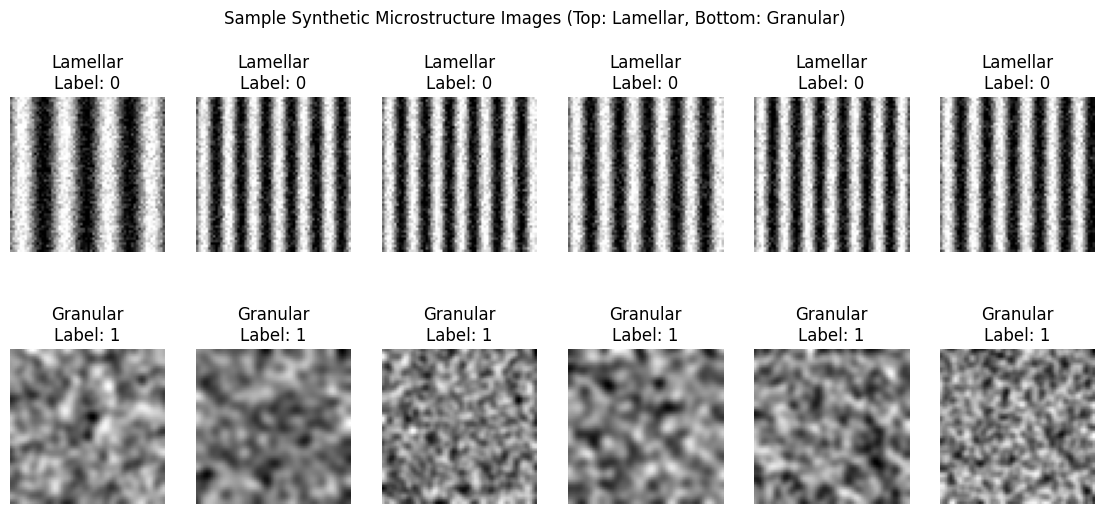

In [ ]:
# %% Cell 3: Generate and Visualize the Synthetic Microstructure Dataset
"""
Generate a synthetic dataset of microstructure images.
We create 200 images (100 per class) with corresponding labels:
0 for lamellar and 1 for granular.
Plot several examples from each class.
"""
def generate_microstructure_dataset(num_per_class=100, img_size=64):
    lamellar_images = []
    granular_images = []

    for _ in range(num_per_class):
        lamellar_images.append(generate_lamellar_image(img_size=img_size, frequency=np.random.uniform(3,7), noise_level=0.1))
        granular_images.append(generate_granular_image(img_size=img_size, noise_level=np.random.uniform(0.4,0.6), sigma=np.random.uniform(1.0,2.0)))

    # Stack and create labels: lamellar -> label 0, granular -> label 1
    images = np.concatenate([np.array(lamellar_images), np.array(granular_images)], axis=0)
    labels = np.concatenate([np.zeros(num_per_class), np.ones(num_per_class)], axis=0)
    return images, labels

# Generate dataset
images, labels = generate_microstructure_dataset(num_per_class=100, img_size=64)
print("Synthetic microstructure dataset generated:")
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Plot a few examples from each class
plt.figure(figsize=(14, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Lamellar\nLabel: {int(labels[i])}")
    plt.axis('off')

for i in range(6):
    plt.subplot(2, 6, i+7)
    idx = 100 + i
    plt.imshow(images[idx], cmap='gray')
    plt.title(f"Granular\nLabel: {int(labels[idx])}")
    plt.axis('off')
plt.suptitle("Sample Synthetic Microstructure Images (Top: Lamellar, Bottom: Granular)")
plt.show()


In [ ]:
# %% Cell 4: Create a PyTorch Dataset for Microstructure Classification
"""
Convert the generated images and labels into a PyTorch Dataset.
Images are normalized and reshaped to include a channel dimension.
The dataset is then split into training and testing sets.
"""
from sklearn.model_selection import train_test_split

class MicrostructureDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (np.array): Array of images with shape [N, H, W].
            labels (np.array): Array of labels with shape [N,].
            transform: Optional transform to be applied on a sample.
        """
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Expand dims to add channel dimension (1, H, W)
        image = self.images[idx][np.newaxis, :, :]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Split dataset into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=seed_val, stratify=labels)
print("Training set size:", train_images.shape[0])
print("Test set size:", test_images.shape[0])

# Create PyTorch datasets and dataloaders
train_dataset = MicrostructureDataset(train_images, train_labels)
test_dataset = MicrostructureDataset(test_images, test_labels)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created for training and testing.")


Training set size: 160
Test set size: 40
DataLoaders created for training and testing.


In [ ]:
# %% Cell 5: Define a CNN Model for Microstructure Image Classification
"""
Define a Convolutional Neural Network (CNN) for classifying microstructure images.
The model consists of several convolutional layers, batch normalization,
ReLU activations, pooling layers, and fully connected layers.
"""
class MicrostructureCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(MicrostructureCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # x shape: [batch_size, 1, 64, 64]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> [batch, 16, 32, 32]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> [batch, 32, 16, 16]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> [batch, 64, 8, 8]
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model and print its summary
model_cnn = MicrostructureCNN(num_classes=2)
print("CNN model for microstructure classification defined:")
print(model_cnn)

CNN model for microstructure classification defined:
MicrostructureCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
# %% Cell 6: Define Training and Evaluation Functions for the CNN
"""
Define functions for training and evaluating the CNN model.
The training function runs through epochs and prints loss,
while the evaluation function computes accuracy on the test set.
"""
def train_cnn(model, train_loader, criterion, optimizer, num_epochs=30, device='cpu'):
    model.to(device)
    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return loss_history

def evaluate_cnn(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

In [ ]:
# %% Cell 7: Train the CNN Model on the Synthetic Microstructure Dataset
"""
Train the CNN model using the training DataLoader.
We use CrossEntropyLoss and the Adam optimizer.
Training loss is recorded and printed every few epochs.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
print("Starting training on device:", device)
loss_history_cnn = train_cnn(model_cnn, train_loader, criterion, optimizer, num_epochs=30, device=device)



Starting training on device: cpu
Epoch 5/30, Loss: 0.0000
Epoch 10/30, Loss: 0.0000
Epoch 15/30, Loss: 0.0000
Epoch 20/30, Loss: 0.0000
Epoch 25/30, Loss: 0.0000
Epoch 30/30, Loss: 0.0000


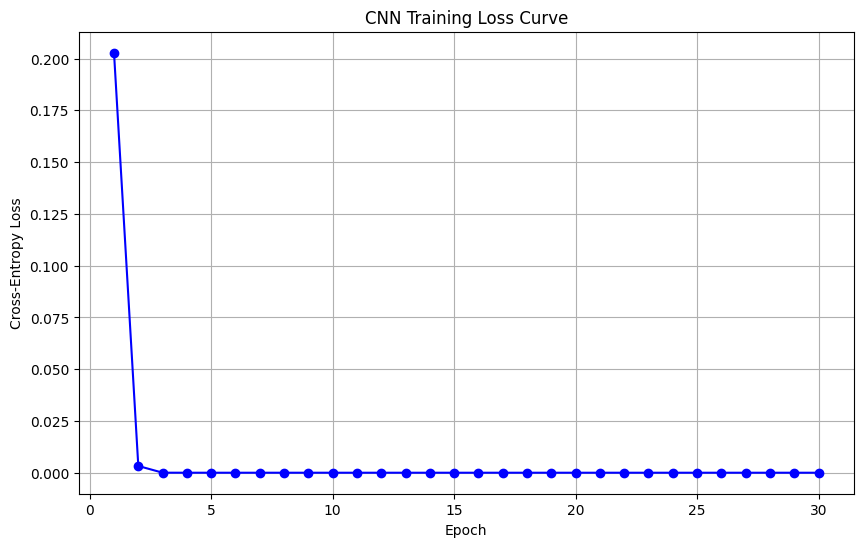

In [ ]:
# %% Cell 8: Plot the Training Loss Curve for the CNN
"""
Plot the training loss curve recorded during training.
A smoothly decreasing loss curve indicates that the model is learning.
"""
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history_cnn)+1), loss_history_cnn, marker='o', color='b')
plt.title("CNN Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()


Test Accuracy: 100.00%


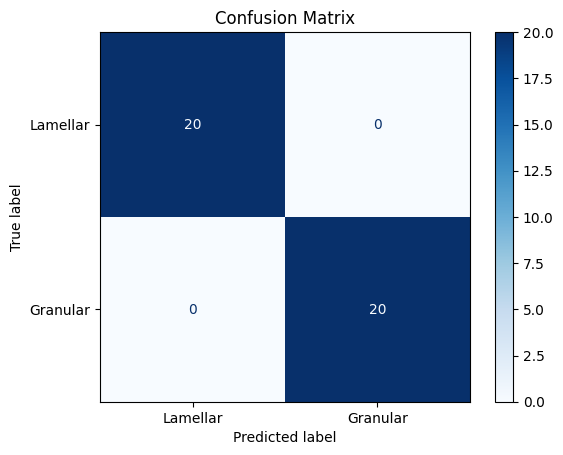

In [ ]:
# %% Cell 9: Evaluate the CNN Model on the Test Set
"""
Evaluate the trained CNN model on the test dataset.
Print the overall classification accuracy and display a confusion matrix.
"""
test_accuracy = evaluate_cnn(model_cnn, test_loader, device=device)

# Optionally, compute and display a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []
model_cnn.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_cnn(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Lamellar", "Granular"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


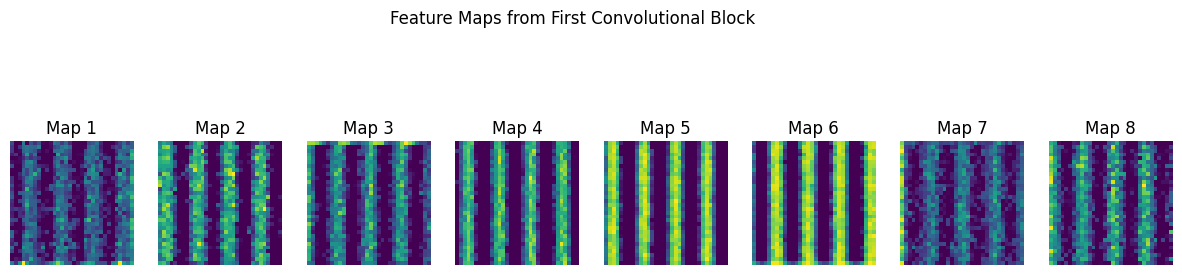

In [ ]:
# %% Cell 10: Visualize Feature Maps from Intermediate CNN Layers
"""
Examine the feature maps produced by the CNN’s first convolutional layer.
This can provide insight into what features are being extracted.
Select one sample image from the test set and display its feature maps.
"""
def get_feature_maps(model, image, device='cpu'):
    """
    Pass the image through the first convolutional block (conv1, bn1, relu, pool)
    and return the feature maps.
    """
    model.to(device)
    model.eval()
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # add batch dimension
        x = model.pool(F.relu(model.bn1(model.conv1(x))))
    return x.cpu().squeeze(0)  # remove batch dimension

# Select a random test image
sample_img, sample_label = test_dataset[random.randint(0, len(test_dataset)-1)]
feature_maps = get_feature_maps(model_cnn, torch.tensor(sample_img), device=device)

num_feature_maps = feature_maps.shape[0]
plt.figure(figsize=(15, 4))
for i in range(min(num_feature_maps, 8)):
    plt.subplot(1, 8, i+1)
    plt.imshow(feature_maps[i], cmap='viridis')
    plt.title(f"Map {i+1}")
    plt.axis('off')
plt.suptitle("Feature Maps from First Convolutional Block")
plt.show()

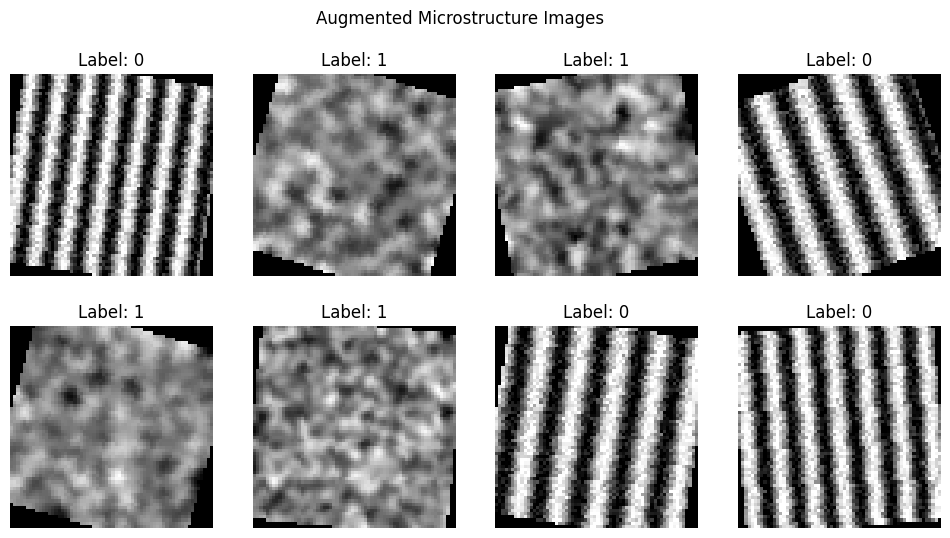

In [ ]:
# %% Cell 11: Data Augmentation Exploration for CNN Robustness
"""
Data augmentation can help improve CNN performance.
Here, we demonstrate simple augmentations such as random rotations and flips.
We create a transformed dataset and visualize a few augmented images.
"""
import torchvision.transforms as transforms

# Define a transformation pipeline for augmentation
augmentation_transforms = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor and scale to [0,1]
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20)
])

class AugmentedMicrostructureDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # shape: [H, W]
        # Convert to PIL image for torchvision transforms (scale to 0-255)
        image = np.uint8(image * 255)
        # Convert grayscale image to PIL image
        from PIL import Image
        image = Image.fromarray(image, mode='L')
        image = self.transform(image)
        # The transform returns a tensor of shape [1, H, W]
        label = self.labels[idx]
        return image, label

# Create an augmented dataset for training
aug_train_dataset = AugmentedMicrostructureDataset(train_images, train_labels, transform=augmentation_transforms)
aug_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True)

# Visualize a few augmented images
plt.figure(figsize=(12, 6))
for i in range(8):
    img, lbl = aug_train_dataset[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(img.squeeze().numpy(), cmap='gray')
    plt.title(f"Label: {int(lbl)}")
    plt.axis('off')
plt.suptitle("Augmented Microstructure Images")
plt.show()

Training CNN model with data augmentation...
Epoch 5/30, Loss: 0.0000
Epoch 10/30, Loss: 0.0000
Epoch 15/30, Loss: 0.0000
Epoch 20/30, Loss: 0.0000
Epoch 25/30, Loss: 0.0000
Epoch 30/30, Loss: 0.0000
Test Accuracy: 100.00%


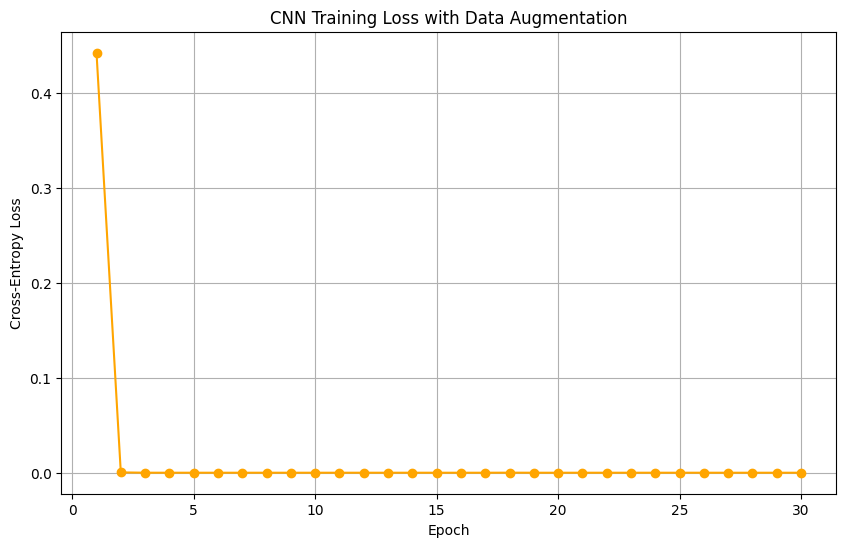

In [ ]:
# %% Cell 12: Retrain the CNN Model with Data Augmentation
"""
Retrain the CNN model using the augmented training data.
Compare the training loss and test accuracy with the original training.
This cell illustrates the benefit of data augmentation.
"""
# Create a new instance of the CNN model
model_cnn_aug = MicrostructureCNN(num_classes=2)
optimizer_aug = optim.Adam(model_cnn_aug.parameters(), lr=0.001)
print("Training CNN model with data augmentation...")
loss_history_cnn_aug = train_cnn(model_cnn_aug, aug_train_loader, criterion, optimizer_aug, num_epochs=30, device=device)
test_accuracy_aug = evaluate_cnn(model_cnn_aug, test_loader, device=device)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history_cnn_aug)+1), loss_history_cnn_aug, marker='o', color='orange')
plt.title("CNN Training Loss with Data Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()

In [ ]:
# %% Cell 13: Save and Reload the Trained CNN Model
"""
Demonstrate how to save the trained CNN model to disk and reload it for future inference.
This is essential for deploying the model in practical applications.
"""
model_save_path_cnn = "microstructure_cnn_model.pth"
torch.save(model_cnn_aug.state_dict(), model_save_path_cnn)
print("CNN model saved to", model_save_path_cnn)

# Reload the model into a new instance
model_cnn_loaded = MicrostructureCNN(num_classes=2)
model_cnn_loaded.load_state_dict(torch.load(model_save_path_cnn))
model_cnn_loaded.eval()
print("CNN model reloaded successfully.")

CNN model saved to microstructure_cnn_model.pth
CNN model reloaded successfully.


<ipython-input-13-12e691d0e154>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn_loaded.load_state_dict(torch.load(model_save_path_cnn))


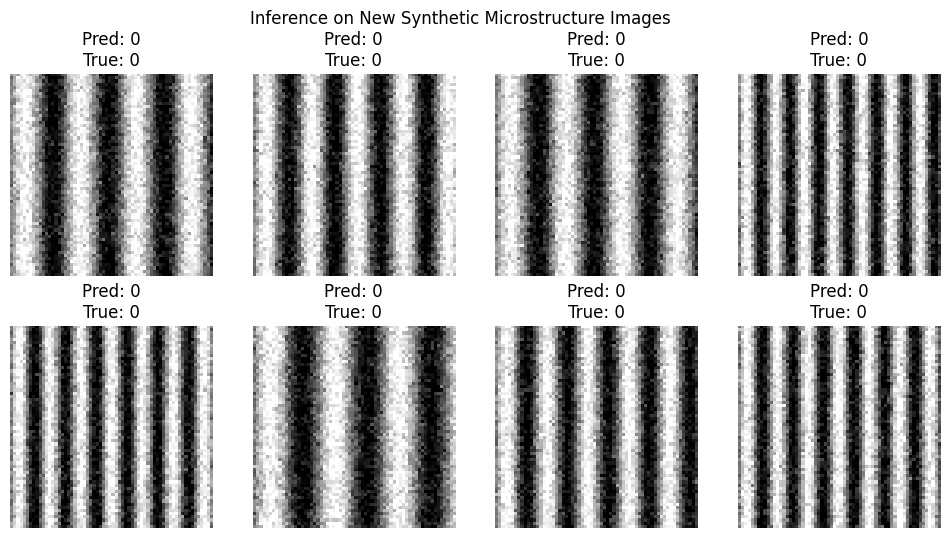

In [ ]:
# %% Cell 14: Inference on New Synthetic Microstructure Images Using the Reloaded Model
"""
Perform inference on a new batch of synthetic microstructure images using the reloaded CNN model.
Display a few images along with their predicted labels and true labels.
"""
# Generate a small new synthetic dataset
new_images, new_labels = generate_microstructure_dataset(num_per_class=10, img_size=64)
new_dataset = MicrostructureDataset(new_images, new_labels)
new_loader = DataLoader(new_dataset, batch_size=8, shuffle=False)

# Get predictions for one batch
model_cnn_loaded.to(device)
model_cnn_loaded.eval()
images_batch, labels_batch = next(iter(new_loader))
images_batch = images_batch.to(device)
with torch.no_grad():
    outputs = model_cnn_loaded(images_batch)
    _, preds = torch.max(outputs, 1)

# Move tensors back to CPU for display
images_batch = images_batch.cpu().numpy()
preds = preds.cpu().numpy()
labels_batch = labels_batch.numpy()

plt.figure(figsize=(12, 6))
for i in range(len(images_batch)):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_batch[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i]}\nTrue: {labels_batch[i]}")
    plt.axis('off')
plt.suptitle("Inference on New Synthetic Microstructure Images")
plt.show()

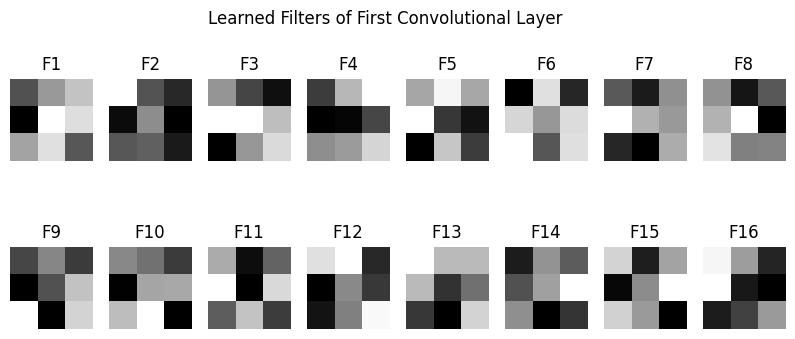

In [ ]:
# %% Cell 15: Visualize the CNN’s Learned Filters
"""
Inspect the learned filters (weights) of the first convolutional layer.
Plot these filters as images to gain insight into the features the CNN is extracting.
"""
filters = model_cnn_loaded.conv1.weight.data.cpu().numpy()  # shape: [16, 1, 3, 3]
plt.figure(figsize=(10, 4))
for i in range(filters.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.imshow(filters[i, 0, :, :], cmap='gray')
    plt.title(f"F{i+1}")
    plt.axis('off')
plt.suptitle("Learned Filters of First Convolutional Layer")
plt.show()


Training CNN model with 2 convolutional layers...
Epoch 5/25, Loss: 0.0000
Epoch 10/25, Loss: 0.0000
Epoch 15/25, Loss: 0.0000
Epoch 20/25, Loss: 0.0000
Epoch 25/25, Loss: 0.0000
Test Accuracy: 100.00%

Training CNN model with 3 convolutional layers...
Epoch 5/25, Loss: 0.0000
Epoch 10/25, Loss: 0.0000
Epoch 15/25, Loss: 0.0000
Epoch 20/25, Loss: 0.0000
Epoch 25/25, Loss: 0.0000
Test Accuracy: 100.00%

Training CNN model with 4 convolutional layers...
Epoch 5/25, Loss: 0.0000
Epoch 10/25, Loss: 0.0000
Epoch 15/25, Loss: 0.0000
Epoch 20/25, Loss: 0.0000
Epoch 25/25, Loss: 0.0000
Test Accuracy: 100.00%
Hyperparameter Tuning Results (Accuracy vs. Number of Conv Layers):
Layers: 2, Accuracy: 100.00%
Layers: 3, Accuracy: 100.00%
Layers: 4, Accuracy: 100.00%


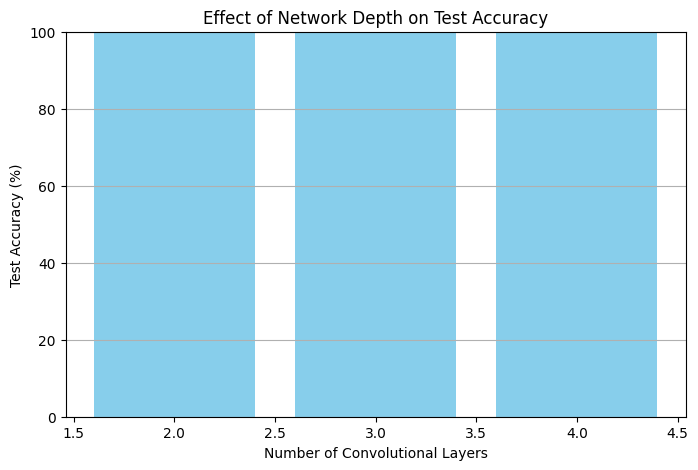

In [ ]:
# %% Cell 16: Hyperparameter Tuning - Varying the Number of Convolutional Layers
"""
Explore the impact of model complexity by modifying the number of convolutional layers.
Train several CNN models with different architectures and compare their performance.
This cell demonstrates the trade-off between network depth and accuracy.
"""
class MicrostructureCNN_Alt(nn.Module):
    def __init__(self, num_layers=2, num_classes=2):
        super(MicrostructureCNN_Alt, self).__init__()
        layers = []
        in_channels = 1
        out_channels = 16
        # Build a variable-depth CNN
        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = out_channels
            out_channels *= 2
        self.conv = nn.Sequential(*layers)
        # Calculate the feature map size after convolutions (assume input 64x64)
        # Each pooling halves the dimension; after num_layers, size = 64/(2^num_layers)
        conv_size = 64 // (2 ** num_layers)
        self.fc = nn.Sequential(
            nn.Linear(in_channels * conv_size * conv_size, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Try different depths: 2, 3, and 4 convolutional layers
depths = [2, 3, 4]
accuracy_results = {}
for depth in depths:
    print(f"\nTraining CNN model with {depth} convolutional layers...")
    model_alt = MicrostructureCNN_Alt(num_layers=depth, num_classes=2)
    optimizer_alt = optim.Adam(model_alt.parameters(), lr=0.001)
    loss_hist = train_cnn(model_alt, train_loader, criterion, optimizer_alt, num_epochs=25, device=device)
    acc = evaluate_cnn(model_alt, test_loader, device=device)
    accuracy_results[depth] = acc

print("Hyperparameter Tuning Results (Accuracy vs. Number of Conv Layers):")
for depth, acc in accuracy_results.items():
    print(f"Layers: {depth}, Accuracy: {acc*100:.2f}%")

# Plot a bar chart of the results
plt.figure(figsize=(8, 5))
plt.bar(list(accuracy_results.keys()), [acc*100 for acc in accuracy_results.values()], color='skyblue')
plt.xlabel("Number of Convolutional Layers")
plt.ylabel("Test Accuracy (%)")
plt.title("Effect of Network Depth on Test Accuracy")
plt.ylim([0, 100])
plt.grid(True, axis='y')
plt.show()

In [ ]:
# %% Cell 17: Final Documentation and Summary of the Notebook
"""
Print a detailed summary of the CNN workflow for microstructure image classification.
This documentation is intended for students to understand each step of the process.
"""
doc_summary = """
Notebook Summary:
-----------------
1. Synthetic Microstructure Dataset:
   - Two types of microstructure images were generated:
       * Lamellar (striped) images representing ordered structures.
       * Granular images representing random textured microstructures.
   - A total of 200 images (100 per class) were created and visualized.
2. Dataset Preparation:
   - The images were converted into a PyTorch Dataset, including a channel dimension.
   - Data were split into training and test sets with an 80/20 ratio.
3. CNN Model Definition:
   - A CNN model was designed with three convolutional layers (with batch normalization, ReLU, and max pooling) followed by fully connected layers.
   - The model was built to classify images into two classes.
4. Training and Evaluation:
   - The model was trained using CrossEntropyLoss and the Adam optimizer.
   - Training loss was recorded and plotted, and test accuracy was computed.
   - A confusion matrix was generated to assess per-class performance.
5. Feature Visualization:
   - Feature maps from the first convolutional block were visualized to understand the model’s early feature extraction.
   - Learned filters from the first layer were also displayed.
6. Data Augmentation:
   - Simple data augmentation techniques (random flips, rotations) were applied to improve model robustness.
   - The effect of augmentation on training loss and accuracy was examined.
7. Model Persistence:
   - The trained model was saved to disk and reloaded to confirm consistency during inference.
8. Hyperparameter Tuning:
   - The impact of network depth (number of convolutional layers) on test accuracy was explored.
   - A comparative analysis was performed, and results were visualized.
9. Future Directions:
   - The notebook demonstrates how CNNs can be applied to materials science by classifying microstructure images.
   - Future research may involve using real microstructure datasets, more advanced architectures, and integrating domain-specific knowledge.
Key Takeaways:
- CNNs are powerful tools for image classification tasks in materials science.
- Synthetic datasets can effectively demonstrate core concepts such as feature extraction and network training.
- Data augmentation and hyperparameter tuning are critical for optimizing model performance.
- Visualizing intermediate features helps in understanding and diagnosing CNN behavior.
"""
print(doc_summary)


Notebook Summary:
-----------------
1. Synthetic Microstructure Dataset:
   - Two types of microstructure images were generated:
       * Lamellar (striped) images representing ordered structures.
       * Granular images representing random textured microstructures.
   - A total of 200 images (100 per class) were created and visualized.
2. Dataset Preparation:
   - The images were converted into a PyTorch Dataset, including a channel dimension.
   - Data were split into training and test sets with an 80/20 ratio.
3. CNN Model Definition:
   - A CNN model was designed with three convolutional layers (with batch normalization, ReLU, and max pooling) followed by fully connected layers.
   - The model was built to classify images into two classes.
4. Training and Evaluation:
   - The model was trained using CrossEntropyLoss and the Adam optimizer.
   - Training loss was recorded and plotted, and test accuracy was computed.
   - A confusion matrix was generated to assess per-class perform

In [ ]:
# %% Cell 18: Final Thoughts and Future Research Directions
"""
Print final thoughts and suggestions for further research.
This cell encourages students to extend the project and consider real-world applications.
"""
final_thoughts = """
Final Thoughts:
---------------
- This notebook showcased a complete pipeline—from synthetic data generation to model training, evaluation, and hyperparameter tuning—for classifying microstructure images.
- The synthetic dataset serves as an educational proxy for real microstructure image data in materials science.
- Potential extensions include:
    * Applying transfer learning with pre-trained CNN models.
    * Incorporating segmentation techniques to analyze microstructure features.
    * Using real experimental datasets and exploring unsupervised or semi-supervised learning.
    * Integrating advanced data augmentation techniques tailored for materials images.
- By understanding these core techniques, students can better appreciate the role of CNNs in analyzing and interpreting microstructure images, ultimately aiding materials design and characterization.
Happy learning and exploration in the intersection of deep learning and materials science!
"""
print(final_thoughts)



Final Thoughts:
---------------
- This notebook showcased a complete pipeline—from synthetic data generation to model training, evaluation, and hyperparameter tuning—for classifying microstructure images.
- The synthetic dataset serves as an educational proxy for real microstructure image data in materials science.
- Potential extensions include:
    * Applying transfer learning with pre-trained CNN models.
    * Incorporating segmentation techniques to analyze microstructure features.
    * Using real experimental datasets and exploring unsupervised or semi-supervised learning.
    * Integrating advanced data augmentation techniques tailored for materials images.
- By understanding these core techniques, students can better appreciate the role of CNNs in analyzing and interpreting microstructure images, ultimately aiding materials design and characterization.
Happy learning and exploration in the intersection of deep learning and materials science!

